# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. The years 2011-2019 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

In [2]:
stations = ['Ceneri', 'Denges', 'Gotthard']

Below shows the 2014 seasonality by day. First it is necessary to remove any holidays or sundays. Sundays can easily be removed with the datetime and the holidays are taking from a list of Ticino holidays.

In [26]:
holidays = ['2014-01-01', '2014-01-06', '2014-03-19', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19', 
            '2014-06-29', '2014-08-01', '2014-08-15', '2014-11-01', '2014-12-07', '2014-12-25', '2014-12-26']

### Truck Weight Seasonality

This section will explore if there is any seasonality with the truck weight/number of trucks within a given time span.

In [5]:
def count_seasonality(station, start_year, end_year, seasonality, pickle):
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the general truck data for normalization
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['Day of year'] = df_truck.Date.dt.dayofyear
    df_truck['Year'] = df_truck.Date.dt.year

    if seasonality == 'Weekly':
        df_truck_hour = df_truck.groupby([truck_count]).Date.count().reset_index().rename(columns={'Date':'count'})
    
    elif seasonality == 'Daily':
        #if minute:
         #   df_platoon['Minute'] = df_platoon.Date.dt.minute
         #   df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Date.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        #else:
        df_truck_hour = df_truck.groupby([truck_count,precision]).Date.count().reset_index().rename(columns={'Date':'count'}) #Total count by weekday/hour

    df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_truck_grouped = df_truck_date.merge(df_truck_hour, on=truck_count)
    df_truck_grouped = df_truck_grouped.set_index(truck_count)
    
    #Normalizing
    df_truck_grouped['norm_count'] = df_truck_grouped['count']/df_truck_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_truck_grouped = df_truck_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_truck_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}.pkl'.format(station, seasonality, start_year, end_year))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_truck_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Count Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_count_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()

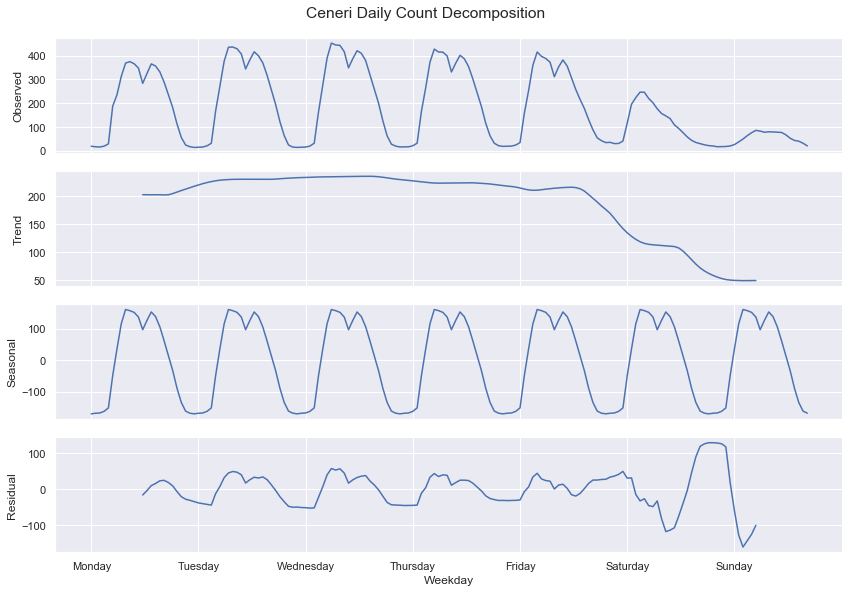

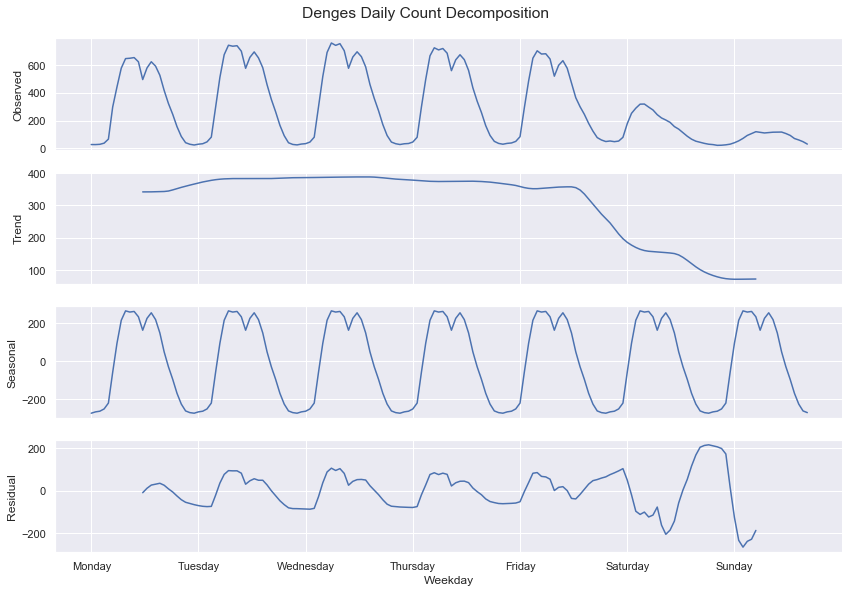

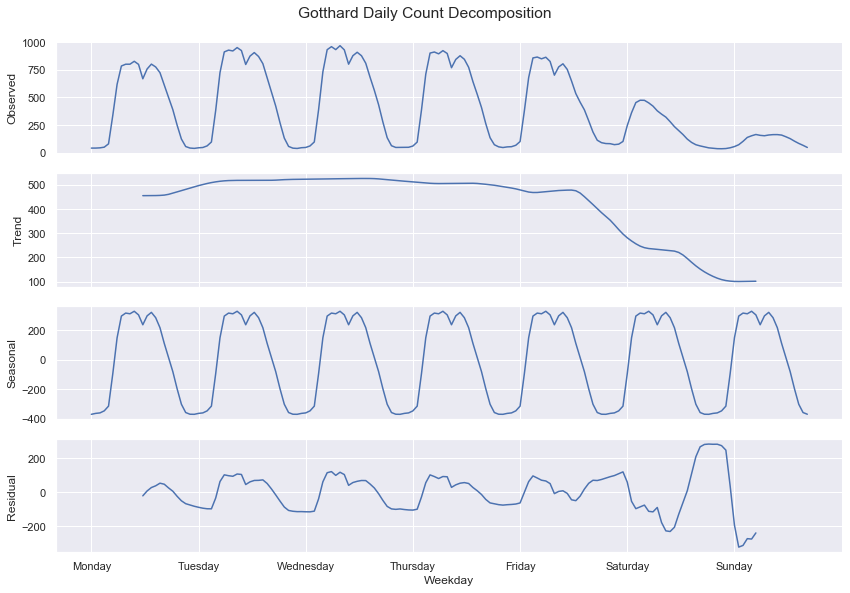

In [22]:
for station in stations:
    count_seasonality(station, 'Daily', False)

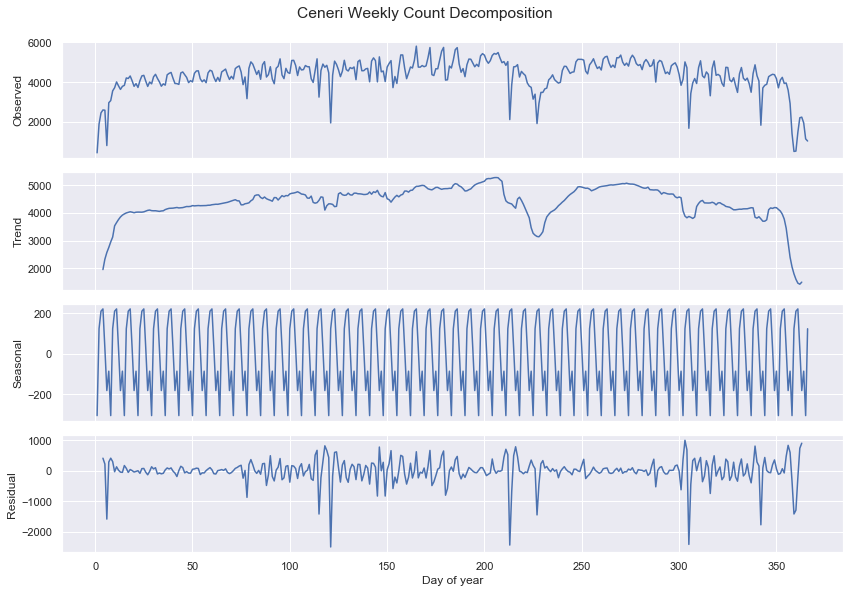

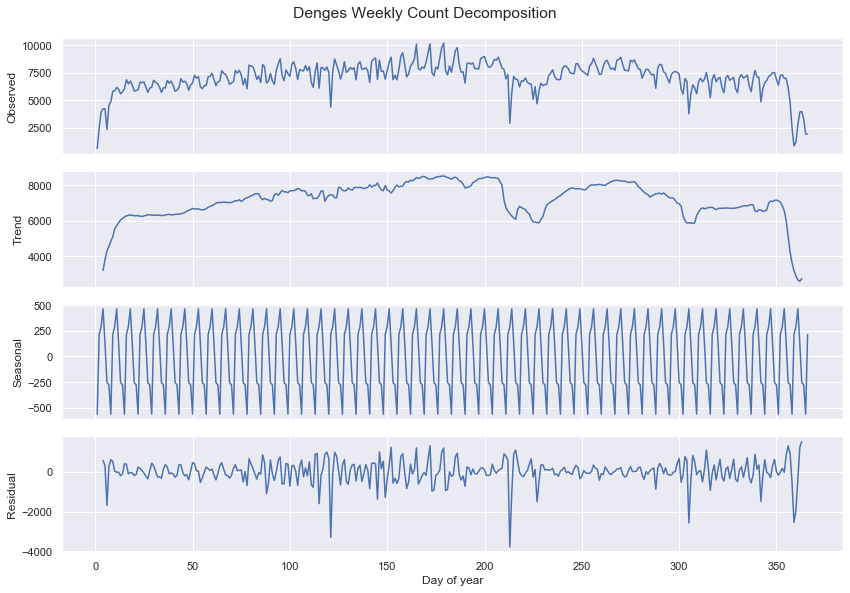

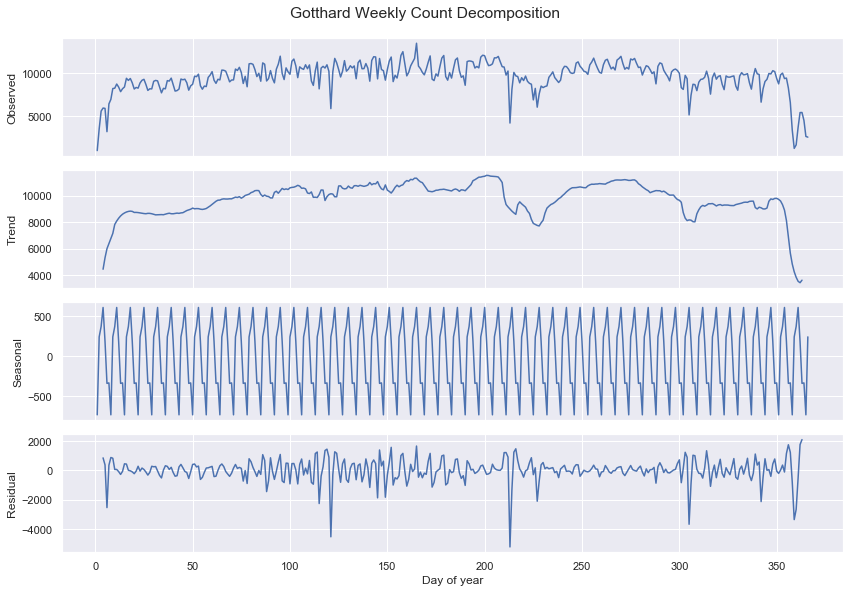

In [25]:
for station in stations:
    count_seasonality(station, 'Weekly', False)

In [6]:
def weight_seasonality(station, start_year, end_year, seasonality):

    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        model = 'additive'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'DoY'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
        model = 'additive'
    
    #Get the general truck data
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    
    #Remove saturday and sunday
    #df_truck = df_truck[~df_truck.Weekday.isin([5, 6])]
    
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['GW_TOT'] = df_truck['GW_TOT']/1000
    
    if seasonality == 'Daily':
        df_truck_hour = df_truck.groupby([truck_count,precision]).GW_TOT.mean()
        
    elif seasonality == 'Weekly':
        df_truck['Day of year'] = df_truck.Date.dt.dayofyear
        df_truck_hour = df_truck.groupby('Day of year').GW_TOT.mean()
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_truck_hour = df_truck_hour.reset_index(1)
        df_truck_hour = df_truck_hour.drop(columns='Hour')
        df_truck_hour = df_truck_hour.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})        
        
    #Plotting
    #df_truck_hour.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
    result = seasonal_decompose(df_truck_hour, model=model, freq=frequency)
    fig = result.plot()
    fig.suptitle('{} {} Weight Decomposition'.format(station, seasonality), y=1.03)
        
    fig.savefig('Figures/{}/{}_weight_season.png'.format(station, seasonality), bbox_inches='tight')
    
    plt.show()    

In [4]:
df = pd.read_pickle('CeneriData/2003_2019_datetime_all.pkl')

In [5]:
df.head()

,ZST,T,ST,FZG_NR,FS,SPEED,LENTH,CS,CSF,GW_TOT,AX,CLASS,AX_W,AX_DIST,Date,Head,HEADx,GAP
0,409,7,1,20196,2,5800,963,21,210,3914,2,0,"[2132, 1782, 0, 0, 0, 0, 0, 0, 0, 0]","[292, 0, 0, 0, 0, 0, 0, 0, 0]",2003-01-01 00:38:09,NaN,NaN,NaN
1,408,7,1,20374,4,10900,658,24,219,4045,2,0,"[1716, 2329, 0, 0, 0, 0, 0, 0, 0, 0]","[367, 0, 0, 0, 0, 0, 0, 0, 0]",2003-01-01 00:54:34,NaN,NaN,NaN
2,408,7,1,20483,4,9800,1199,23,520,14932,2,11,"[5393, 9539, 0, 0, 0, 0, 0, 0, 0, 0]","[577, 0, 0, 0, 0, 0, 0, 0, 0]",2003-01-01 01:02:28,NaN,NaN,NaN
3,408,7,1,20493,4,12500,455,21,210,3973,2,0,"[2043, 1930, 0, 0, 0, 0, 0, 0, 0, 0]","[278, 0, 0, 0, 0, 0, 0, 0, 0]",2003-01-01 01:02:56,NaN,NaN,NaN
4,408,7,1,20874,4,10400,1208,23,520,15085,2,11,"[5617, 9468, 0, 0, 0, 0, 0, 0, 0, 0]","[581, 0, 0, 0, 0, 0, 0, 0, 0]",2003-01-01 01:37:23,NaN,NaN,NaN


In [6]:
def reindex_series_weight(df):
    df['DateHour'] = df.Date.dt.round('H')
    df = df.set_index(df.DateHour)
    new_idx = pd.date_range(df.index[0].date(), df.index[-1].date(), freq='H')
    df = df.drop(columns='DateHour')
    df = df.groupby('DateHour').GW_TOT.mean()
    df = df.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)
    df = df.fillna(0)
    df = df.reindex(new_idx) #Remove the filter so that the Nans remain
    return df

In [7]:
df_weight = reindex_series_weight(df)

In [10]:
import numpy as np

In [13]:
day_ticks = np.arange(12, 167, 24)
day_dict={36: "Tuesday", 60: "Wednesday", 84: "Thursday", 108: 'Friday', 132: 'Saturday',
                                                     156: 'Sunday', 12:'Monday'}

In [18]:
#Normalize to tons
df_weight = df_weight/1000

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean heavy vehicles average weight per hour per day of week')

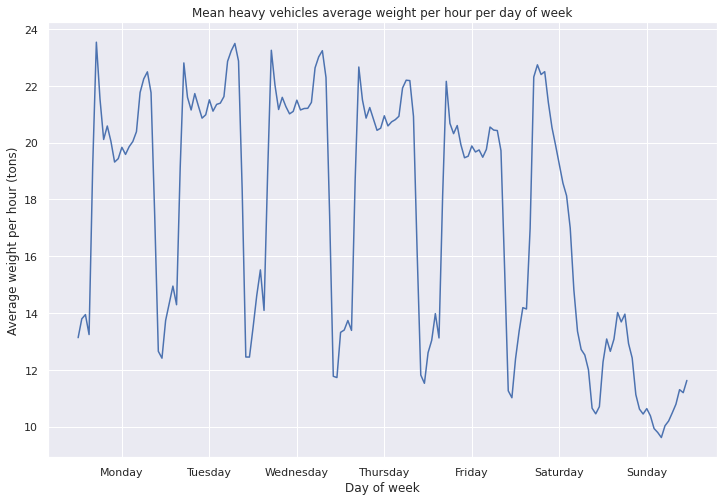

In [20]:
shift = df_weight[:120]
df_try = pd.concat([df_weight[121:], shift]).reset_index()
#df_try = df_weight.reset_index()
fig, ax = plt.subplots()
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)
sns.lineplot(df_try['Hour_week'], df_try['GW_TOT'], legend=False)
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Average weight per hour (tons)')
ax.set_title('Mean heavy vehicles average weight per hour per day of week')


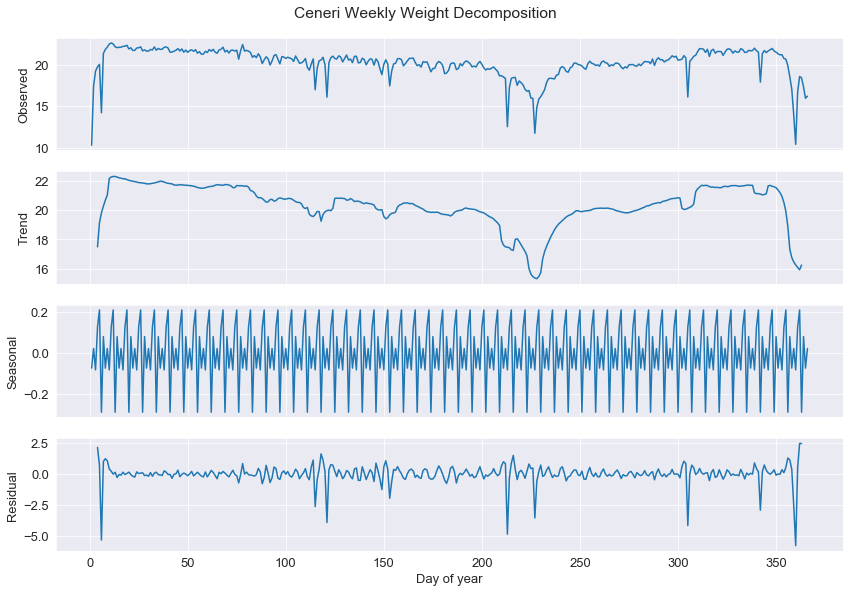

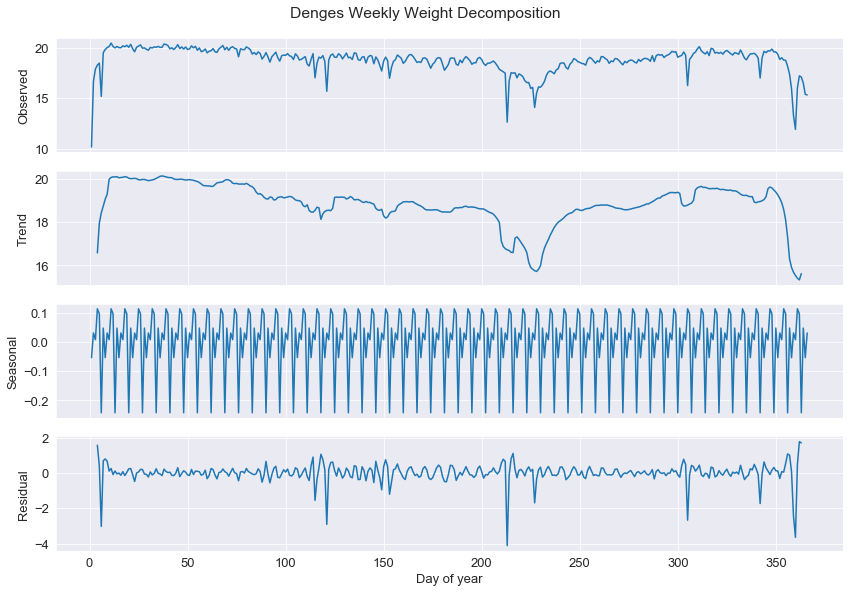

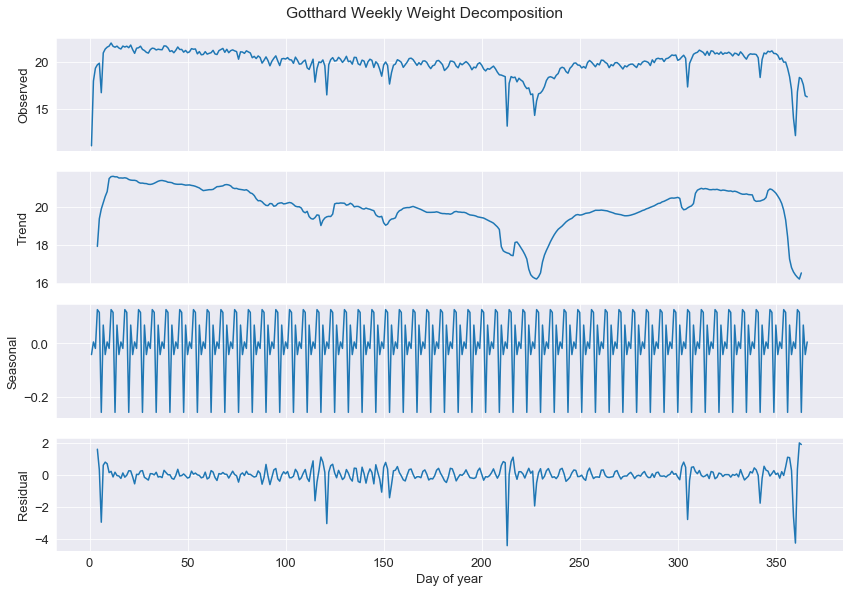

In [52]:
for station in stations:
    #weight_seasonality(station, 'Daily')
    weight_seasonality(station, 'Weekly')

## Platoon Seasonality

This section will take the platoons found in the PlatoonFinding folder and plot the beginning time of the platoon, grouping by hour and day of the week.

In [7]:
def platoon_seasonality(station, start_year, end_year, headway, seasonality, minute, pickle):
    
    if seasonality == 'Daily':
        frequency = 24
        truck_count = 'Weekday'
        seasonal = 'Date_d'
        precision = 'Hour'
        
    elif seasonality == 'Weekly':
        frequency = 7
        truck_count = 'Day of year'
        seasonal = 'Date_d'
        precision = 'Date_d'
        months = [3, 4, 5] #Taking months March, April, May
    
    #Get the platoon data
    df_platoon = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway))
    #df_platoon = df_platoon[df_platoon.Length > 1] #Only keep platoons that are at least of length 2
    df_platoon['Weekday'] = df_platoon.Start.dt.weekday
    df_platoon['Hour'] = df_platoon.Start.dt.hour
    df_platoon['Date_d'] = df_platoon.Start.dt.date
    df_platoon['Day of year'] = df_platoon.Start.dt.dayofyear
    df_platoon['Year'] = df_platoon.Start.dt.year

    
    #Get the general truck data for normalization
    df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
    df_truck['Weekday'] = df_truck.Date.dt.weekday
    df_truck['Hour'] = df_truck.Date.dt.hour
    df_truck['Date_d'] = df_truck.Date.dt.date
    df_truck['Day of year'] = df_truck.Date.dt.dayofyear
    df_truck['Year'] = df_truck.Date.dt.year

    if seasonality == 'Weekly':
        df_platoon_hour = df_platoon.groupby([truck_count]).Start.count().reset_index().rename(columns={'Start':'count'})
    
    elif seasonality == 'Daily':
        if minute:
            df_platoon['Minute'] = df_platoon.Start.dt.minute
            df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
        else:
            df_platoon_hour = df_platoon.groupby([truck_count,precision]).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour

    df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
    df_platoon_grouped = df_truck_date.merge(df_platoon_hour, on=truck_count)
    df_platoon_grouped = df_platoon_grouped.set_index(truck_count)
    
    #Normalizing
    df_platoon_grouped['norm_count'] = df_platoon_grouped['count']/df_platoon_grouped['seasonal_count']
    
    #Renaming days of the week
    if seasonality == 'Daily':
        df_platoon_grouped = df_platoon_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})
    
    if pickle:
        df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}.pkl'.format(station, seasonality, start_year, end_year, headway))
    else:
        #Plotting
        #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
        result = seasonal_decompose(df_platoon_grouped.norm_count, model='additive', freq=frequency)
        fig = result.plot()

        fig.suptitle('{} {} Platoon Decomposition'.format(station, seasonality), y=1.03)

        fig.savefig('Figures/{}/{}_platoon_season.png'.format(station, seasonality), bbox_inches='tight')

        plt.show()

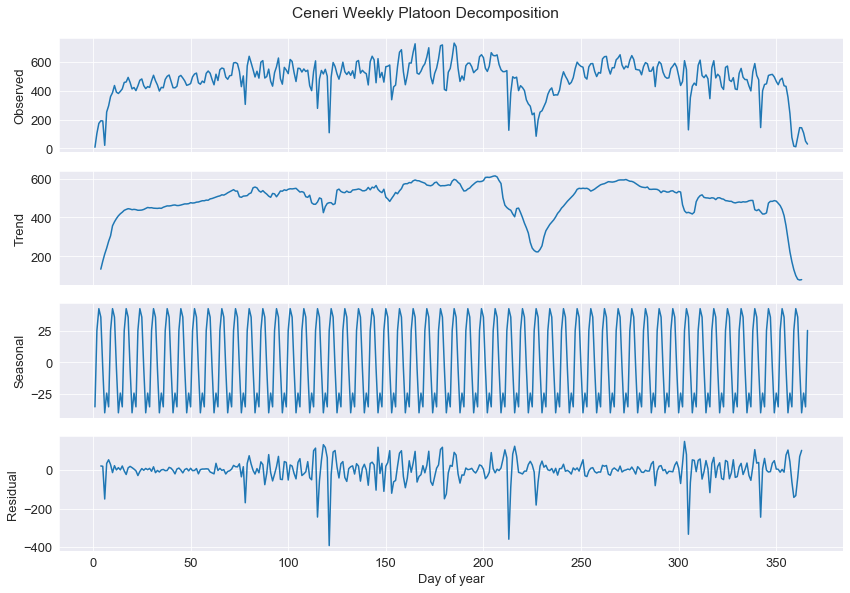

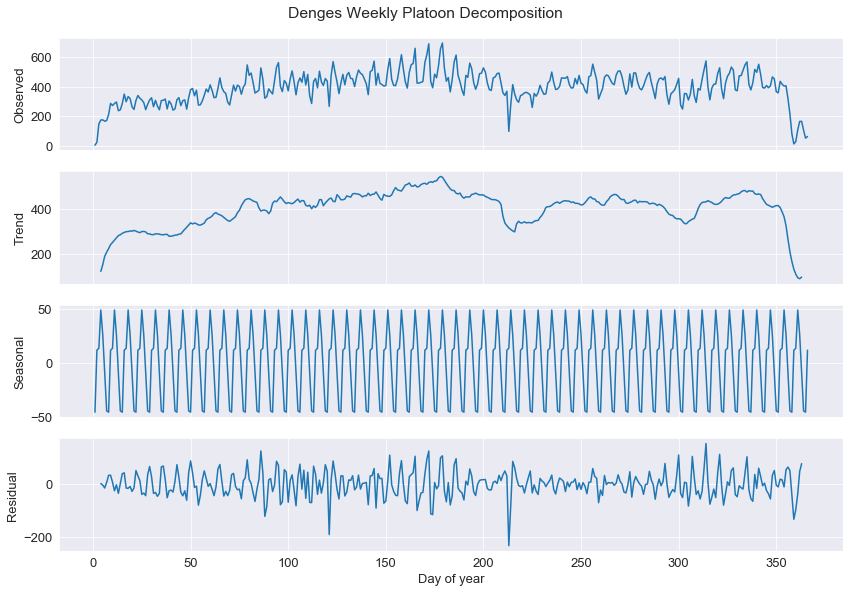

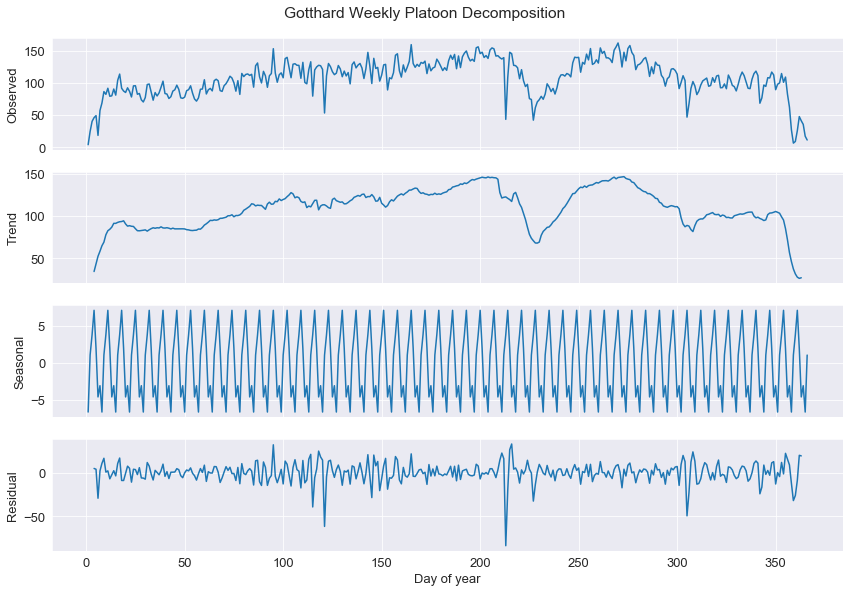

In [56]:
for station in stations:
    platoon_seasonality(station, 'Weekly')

In [9]:
for station in stations:
    platoon_seasonality(station, 'Daily', True, True)

In [22]:
df = pd.read_pickle('CeneriData/2003_2019_platoon_h2.4_lane4.pkl')

In [41]:
def reindex_series_platoon(df):
    df['DateHour'] = df.Start.dt.round('H')
    df = df.set_index(df.DateHour)
    new_idx = pd.date_range(df.index[0].date(), df.index[-1].date(), freq='H')
    df = df.drop(columns='DateHour')
    df = df.groupby('DateHour').Length.sum()
    df = df.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)
    df = df.fillna(0)
    df = df.reindex(new_idx) #Remove the filter so that the Nans remain
    return df

In [45]:
df_platoon = reindex_series_platoon(df[df.Length > 1])

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df_1 = reindex_series_platoon(df[df.Length == 1])

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean heavy vehicles in groups with more than 2 vehicles count per hour per day of week')

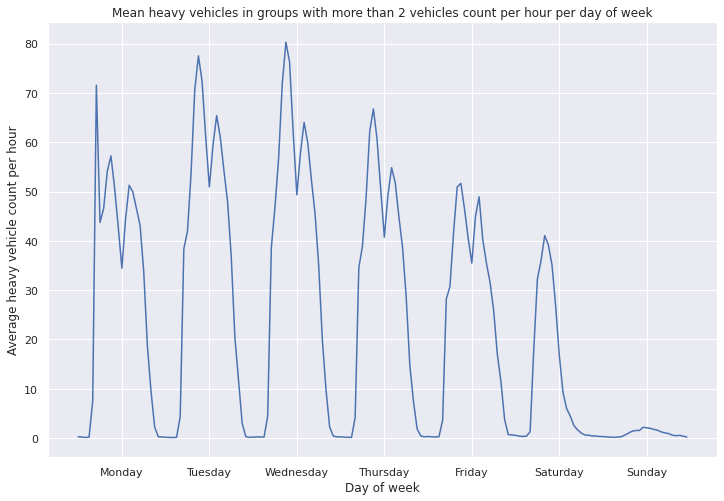

In [47]:
#Platoon seasonality with only the platoons from lane 4
#Not normalized, not sure why that was originally necessary?? 
shift = df_platoon[:120]
df_try = pd.concat([df_platoon[121:], shift]).reset_index()
#df_try = df_platoon.reset_index()
fig, ax = plt.subplots()
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)
sns.lineplot(df_try['Hour_week'], df_try['Length'], legend=False)
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Average heavy vehicle count per hour')
ax.set_title('Mean heavy vehicles in groups with more than 2 vehicles count per hour per day of week')

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean heavy vehicles in groups with 1 vehicle count per hour per day of week')

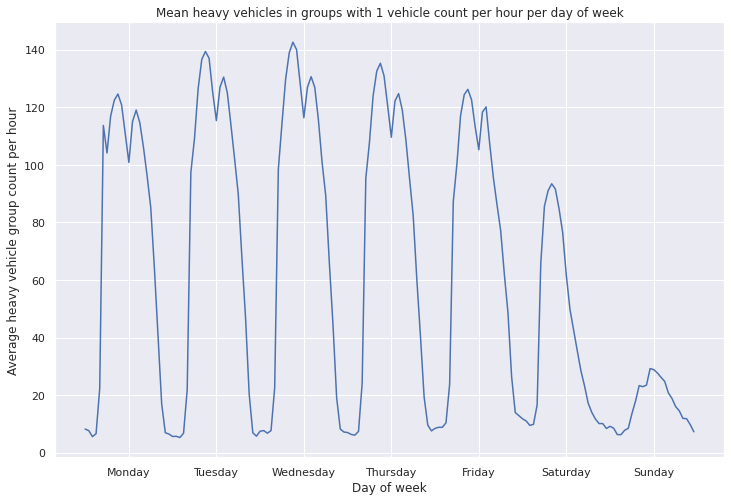

In [48]:
#Platoon seasonality with only the platoons from lane 4
#Not normalized, not sure why that was originally necessary?? 
shift = df_1[:120]
df_try = pd.concat([df_1[121:], shift]).reset_index()
#df_try = df_1.reset_index()
fig, ax = plt.subplots()
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)
sns.lineplot(df_try['Hour_week'], df_try['Length'], legend=False)
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Average heavy vehicle group count per hour')
ax.set_title('Mean heavy vehicles in groups with 1 vehicle count per hour per day of week')

### Correlation

This section aims to investigate the correlation between features to see which features are correlated together, particularly with time.

In [94]:
df = pd.read_csv('{}Data/2011_2018_datetime.csv'.format(Station), index_col=0, parse_dates=['Date']) 

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [95]:
df.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3500,0,408,674,5,2011-01-01 00:54:14
1,4,5270,0,408,839,8,2011-01-01 00:54:48
2,4,19280,12,408,1429,10,2011-01-01 02:43:02
3,4,4400,0,408,742,5,2011-01-01 02:54:33
4,4,4090,0,408,819,8,2011-01-01 03:12:30


In [97]:
df['weekday'] = df.Date.dt.weekday

In [99]:
df['hour'] = df.Date.dt.hour

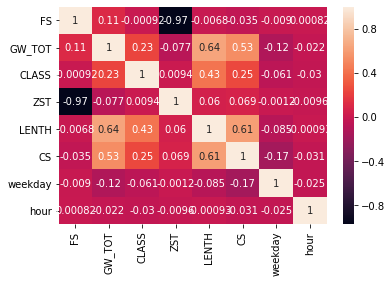

In [100]:
import matplotlib.pyplot as plt
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()